# Agent Learning Project

## Imports 

We start by importing the required libaries. Uncomment & run the next cell in case some of the libraries aren't installed in your environment. 

In [1]:
# !pip install numpy matplotlib

In [2]:
import numpy as np # Useful for computations and probabilistic distributions
import matplotlib.pyplot as plt # Plotting Graph for Simulation results
from collections import defaultdict # Specific kind of dictionary that avoids KeyErrors

## Defining the Agent class

We define a type of agent with the following attributes: 
- Agent name : Name of the agent
- Service probability : If at the counter, shows the probability that this agent will be serviced.
- Reward : Reward the counter gets for servicing this agent
- Time in queue : Time for which the agent has been in the queue. 

In [3]:
class Agent:
    def __init__(self, name):
        self.name = name
        self.service_prob, self.reward, self.penalty = agents[name][:3]
        self.penalty_function = agents[name][4]
        self.time_in_queue = 0

    def __str__(self):
        return f"Agent {self.name} ({self.time_in_queue})"

## Defining the Queue mechanism 

In [4]:
class QueueSimulation:
    def __init__(self, agents, arrival_prob, strategy, init, alpha, discount):
        # Define the agents, their distribution, and the strategy
        self.agents = agents
        self.agent_distribution = np.array([agent[3] for agent in agents.values()])
        self.agent_distribution = self.agent_distribution / np.sum(self.agent_distribution)
        self.strategy = strategy
        
        # Define the hyper-parameters of the simulation
        self.arrival_prob, self.init, self.alpha = arrival_prob, init, alpha
        self.fixed_discount, self.discount = discount, 1 # Optimization trick to avoid recomputing power at each step
        
        # Define the Queue
        self.queue = [self.create_agent() for _ in range(init)] if type(init) == int else init
        self.current_agent = None if len(self.queue) == 0 else self.queue[0]
        
        # Variables that are used to analyze our code
        self.time, self.busy, self.total_reward, self.discounted_reward = 0, 0, 0, 0
        
        # Tracking the history for graphs
        self.serviced_agents = defaultdict(int)
        self.reward_history, self.queue_length_history = [], []

    def create_agent(self):
        name = np.random.choice(list(self.agents.keys()), p=self.agent_distribution)
        return Agent(name)

    def step(self):
        """
        This function is the core of the simulation. It defines what happens at every step. The order in which 
        the computations are made is important so we have to be careful. In our case, we proceed as follows:
        
        1. Determine whether an agent is joining the queue
        2. Detemine if the agent in service is going to complete service or not and potentially add reward 
        3. Apply the given strategy to determine what happens next
        4. Add penalty to the reward
        5. Add the information related to the step to the simulation history
        """
        self.time += 1 # Update time
        self.discount *= self.fixed_discount # Update Discount
        
        # Add new agent to the queue based on arrival probability
        if np.random.rand() < self.arrival_prob:
            new_agent = self.create_agent()
            self.queue.append(new_agent)

        # Check if the current agent is done being served
        if self.current_agent:
            if np.random.rand() < self.current_agent.service_prob:
                self.total_reward += self.current_agent.reward
                self.discounted_reward += self.current_agent.reward*self.discount
                self.serviced_agents[self.current_agent.name] += 1
                self.current_agent = None
                
        # Apply the strategy to select the next agent
        if self.queue:
            queue_index = self.strategy(self.queue,self.current_agent)
            self.swap_agents(queue_index)
        
        length = len(self.queue)
        
        # Apply penalty on reward
        for agent in self.queue: 
            agent.time_in_queue += 1
            self.total_reward -= agent.penalty_function(self.time, agent.penalty)
            self.discounted_reward -= agent.penalty_function(self.time, agent.penalty*self.discount)
        self.total_reward -= regularization(self.alpha,length)
        self.discounted_reward -= regularization(self.alpha,length)*self.discount
        
        # Add the step's information to the simulation history
        self.reward_history.append(self.total_reward)
        self.queue_length_history.append(length+bool(self.current_agent))
        self.busy += bool(self.current_agent)

    def swap_agents(self, queue_index):
        if 0 <= queue_index < len(self.queue):
            if self.current_agent:
                self.queue[queue_index], self.current_agent = (self.current_agent,self.queue[queue_index])
            else:
                self.current_agent = self.queue.pop(queue_index)

    def run_simulation(self, steps=1000):
        for _ in range(steps):
            self.step()

    def get_results(self):
        # Plot total reward over time
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.reward_history)
        plt.title('Total Reward over Time')
        plt.xlabel('Time')
        plt.ylabel('Total Reward')

        # Plot queue length over time
        plt.subplot(1, 3, 2)
        plt.plot(self.queue_length_history)
        plt.title('Queue Length over Time')
        plt.xlabel('Time')
        plt.ylabel('Queue Length')

        # Plot distribution of serviced agents by type
        plt.subplot(1, 3, 3)
        agent_types, counts = zip(*sorted(self.serviced_agents.items()))
        plt.bar(agent_types, counts)
        plt.title('Distribution of Serviced Agents by Type')
        plt.xlabel('Agent Type')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.show()
        
        self.min_queue_length = np.min(self.queue_length_history)
        self.max_queue_length = np.max(self.queue_length_history)
        self.mean_queue_length = np.mean(self.queue_length_history)
        self.normalized_distribution = {agent_type: round(count / sum(self.serviced_agents.values()), 3) for agent_type, count in sorted(self.serviced_agents.items(), key=lambda item: item[1], reverse=True)}

        
        print(f"\nTotal reward: {self.total_reward}")
        print(f"Discounted reward: {self.discounted_reward}")
        print(f"Average reward per step: {self.total_reward/self.time}")
        print(f"Min & Max Queue Length: {self.min_queue_length} & {self.max_queue_length}")
        print(f"Mean Queue Length: {self.mean_queue_length}")
        print(f"Normalized Distribution of Serviced Agents: {self.normalized_distribution}")
        print(f"Time spent busy: {self.busy/self.time}")
        print(f"--------------------------------------------------------")


In [5]:
# Compute average service probability
def service():
    service_prob = np.array([agent[0] for agent in agents.values()])
    weights = np.array([agent[3] for agent in agents.values()])
    distribution = weights / np.sum(weights)
    x = np.dot(service_prob, distribution.T)
    return x,1/x

# Compute expect reward per agent
def average():
    probabilities = np.array([agent[0] for agent in agents.values()])
    rewards = np.array([agent[1] for agent in agents.values()])
    penalties = np.array([agent[2] for agent in agents.values()])
    average_values = {agent: (rewards[i] + penalties[i]) / probabilities[i] for i, agent in enumerate(agents.keys())}
    return average_values

# Create the initial list
def create(l, shuffle=False):
    queue = []
    for name, quantity in l:
        queue += [Agent(name)] * quantity
    if shuffle:
        np.random.shuffle(queue)
    return queue

## Defining strategies

In [6]:
def priority_list(queue, current_agent):
    if current_agent:
        current_priority = fixed_priority.index(current_agent.name)
        min_queue_priority = min(fixed_priority.index(agent.name) for agent in queue)
        if current_priority <= min_queue_priority:
            return -1
    return min(range(len(queue)), key=lambda i: fixed_priority.index(queue[i].name))

def first_in_first_served(queue, current_agent):
    return -1 if current_agent else 0

def dynamic_strategy(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: current_agent.time_in_queue if i == -1 else queue[i].time_in_queue)
    return max(range(len(queue)), key=lambda i: queue[i].time_in_queue)

def shortest_service_time_first(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: current_agent.service_prob if i == -1 else queue[i].service_prob)
    return max(range(len(queue)), key=lambda i: queue[i].service_prob)

def highest_reward_first(queue, current_agent):
    if current_agent:
        return max(range(-1, len(queue)), key=lambda i: current_agent.reward if i == -1 else queue[i].reward)
    return max(range(len(queue)), key=lambda i: queue[i].reward)

def random_selection(queue, current_agent):
    return np.random.randint(-1, len(queue)) if current_agent else np.random.randint(0, len(queue))

def dynamic_priority(queue, current_agent):
    priority = {agent: agents[agent][0] * agents[agent][2] for agent in agents}
    priority = sorted(priorities.keys(), key=lambda agent: priorities[agent], reverse=True)
    if current_agent:
        current_priority = priority.index(current_agent.name)
        min_queue_priority = min(priority.index(agent.name) for agent in queue)
        if current_priority <= min_queue_priority:
            return -1
    return min(range(len(queue)), key=lambda i: priority.index(queue[i].name))

### Explanations of strategies

- **priority_list**: Selects agents based on a predefined priority list.
- **first_in_first_served**: Selects the first agent in the queue.
- **dynamic_strategy**: Selects the agent who has been waiting the longest.
- **shortest_service_time_first**: Selects the agent with the shortest service time.
- **highest_reward_first**: Selects the agent with the highest reward.
- **random_selection**: Selects an agent randomly from the queue.
- **dynamic_priority**: Best penalty to expected service time ratio

The next step could be to implement more complex dynamic strategies and Machine Learning based strategies.

## Choosing base parameters

In [7]:
# Penalty functions
def penalty_func_constant(time_in_queue, penalty_value):
    return penalty_value
    
def penalty_func_linear(time_in_queue, penalty_value):
    return penalty_value * time_in_queue
    
# Defining Agents
agents = {
    ### Agent name : [service_probability, reward, penalty, distrib_weight]
    # service_probability: float in [0,1]
    # reward, penalty, distrib_weight: float (unconstrained)
    "Alex" : [0.7, 1, 0.1, 6, penalty_func_constant], 
    "Ben" : [0.5, 20, 0.4, 3, penalty_func_constant],
    "Cameron" : [0.3, 30, 0.2, 4, penalty_func_constant],
    "Dennis" : [0.4, 20, 0.01, 2, penalty_func_constant],
    "Eric": [0.8, 4, 0.2, 3, penalty_func_constant],
    "Fabien": [0.5, 50, 0.4, 1, penalty_func_constant],
}

# Probabilty that a new agent joins the queue
arrival_prob = 0.5

# Number of agents in the queue at t = 0
# We either choose a random weighted queue or a specific queue
start = 0
queue = create([("Fabien", 20), ("Alex", 10)], True) # [(name, quantity),(name, quantity),...], shuffle=True/False 
init = start # Choose a mode here

# Choose a discount factor for discounted reward computation
discount = 0.99

# Regularization parameter and function
alpha = 0.00
def regularization(alpha,length):
    return alpha*length

## Playing the game according to predetermined strategies

Execute the main code automatically by choosing one of the strategies defined above in the 'Define Strategies' section and letting the computer play by itself. This function outputs three graphs. 
- Graph 1: Total reward from time $t_0$ to time $t_{1000}$.
- Graph 2: Length of the Queue from time $t_0$ to time $t_{1000}$.
- Graph 3: Distribution of serviced Agents by type from $t_0$ to time $t_{1000}$.



### Running a specific strategy

Automatic simulation with strategy 'priority_list'
Expected service probability & time across agents: (0.5578947368421051, 1.7924528301886797)
Expected reward + weighted penalty for each agent: {'Alex': 1.5714285714285716, 'Ben': 40.8, 'Cameron': 100.66666666666667, 'Dennis': 50.025, 'Eric': 5.25, 'Fabien': 100.8}


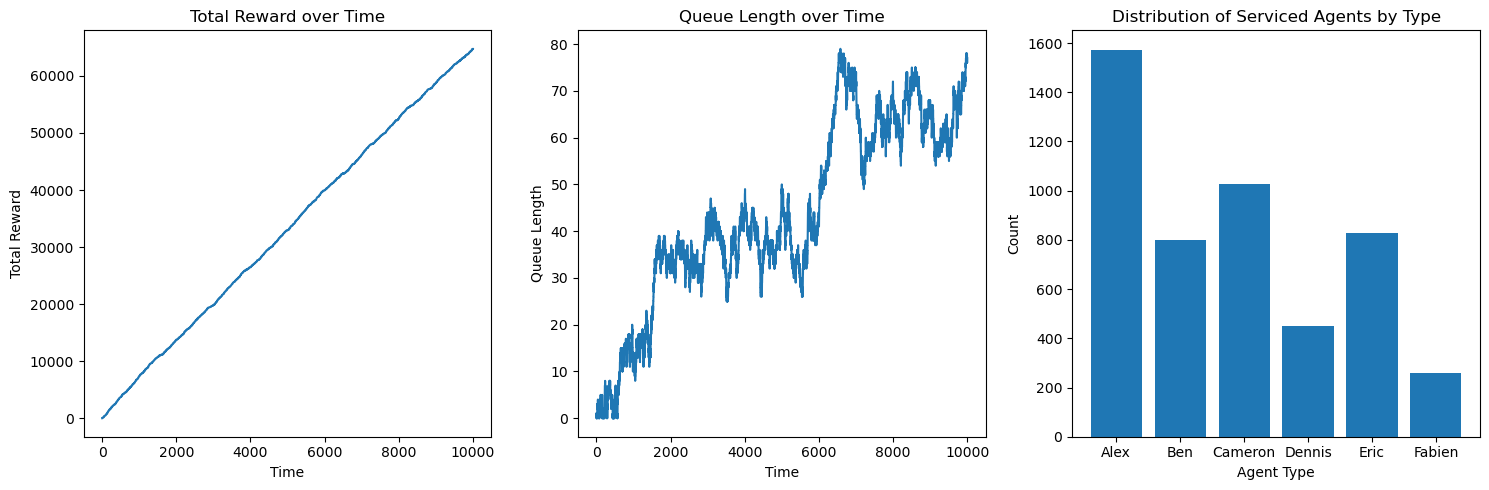


Total reward: 64746.4599995912
Discounted reward: 678.3625928048667
Average reward per step: 6.47464599995912
Min & Max Queue Length: 0 & 79
Mean Queue Length: 43.591
Normalized Distribution of Serviced Agents: {'Alex': 0.319, 'Cameron': 0.209, 'Eric': 0.167, 'Ben': 0.162, 'Dennis': 0.091, 'Fabien': 0.052}
Time spent busy: 0.9929
--------------------------------------------------------


In [8]:
# Choosing the strategy (full list of strategies above)
fixed_priority = ["Fabien","Eric","Ben", "Alex",  "Cameron", "Dennis"]
strategy = priority_list

simulation = QueueSimulation(
    agents,
    arrival_prob,
    strategy,
    init,
    alpha,
    discount,
)

print(f"Automatic simulation with strategy '{strategy.__name__}'")
print(f"Expected service probability & time across agents: {service()}")
print(f"Expected reward + weighted penalty for each agent: {average()}")
simulation.run_simulation(steps=10000)
simulation.get_results()

### Comparing strategies

Expected service probability & time across agents: (0.5578947368421051, 1.7924528301886797)
Expected reward + weighted penalty for each agent: {'Alex': 1.5714285714285716, 'Ben': 40.8, 'Cameron': 100.66666666666667, 'Dennis': 50.025, 'Eric': 5.25, 'Fabien': 100.8}
---------------------------------------------------
Running simulation with strategy 'priority_list'


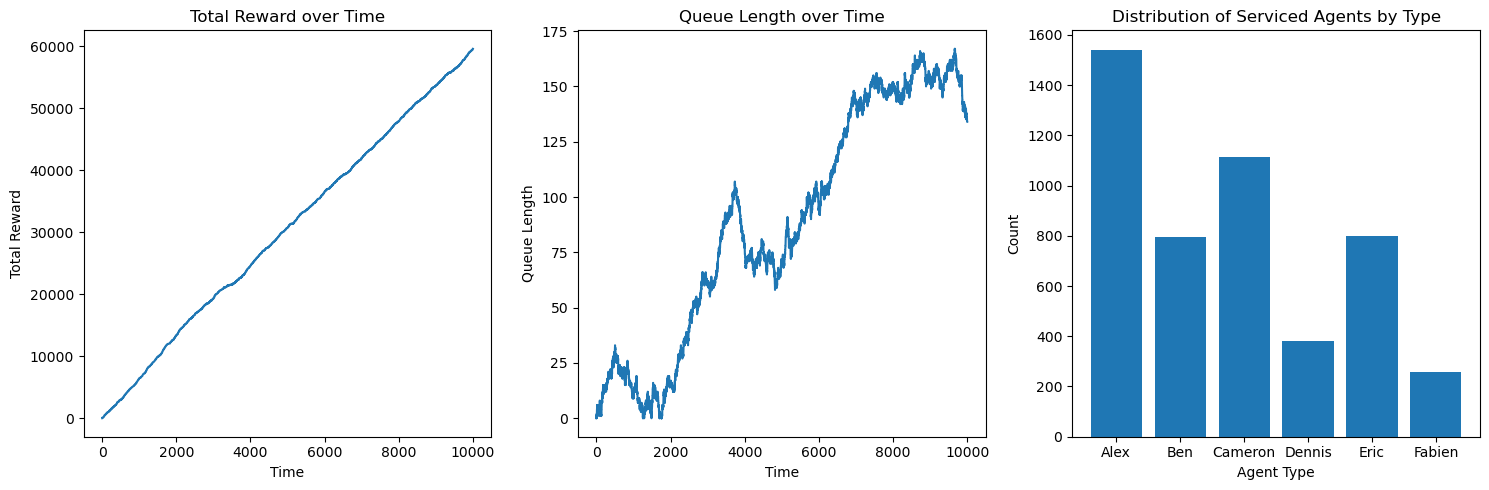


Total reward: 59601.34999906539
Discounted reward: 627.6162892859157
Average reward per step: 5.960134999906539
Min & Max Queue Length: 0 & 167
Mean Queue Length: 87.9807
Normalized Distribution of Serviced Agents: {'Alex': 0.315, 'Cameron': 0.228, 'Eric': 0.164, 'Ben': 0.163, 'Dennis': 0.078, 'Fabien': 0.053}
Time spent busy: 0.9972
--------------------------------------------------------
Running simulation with strategy 'first_in_first_served'


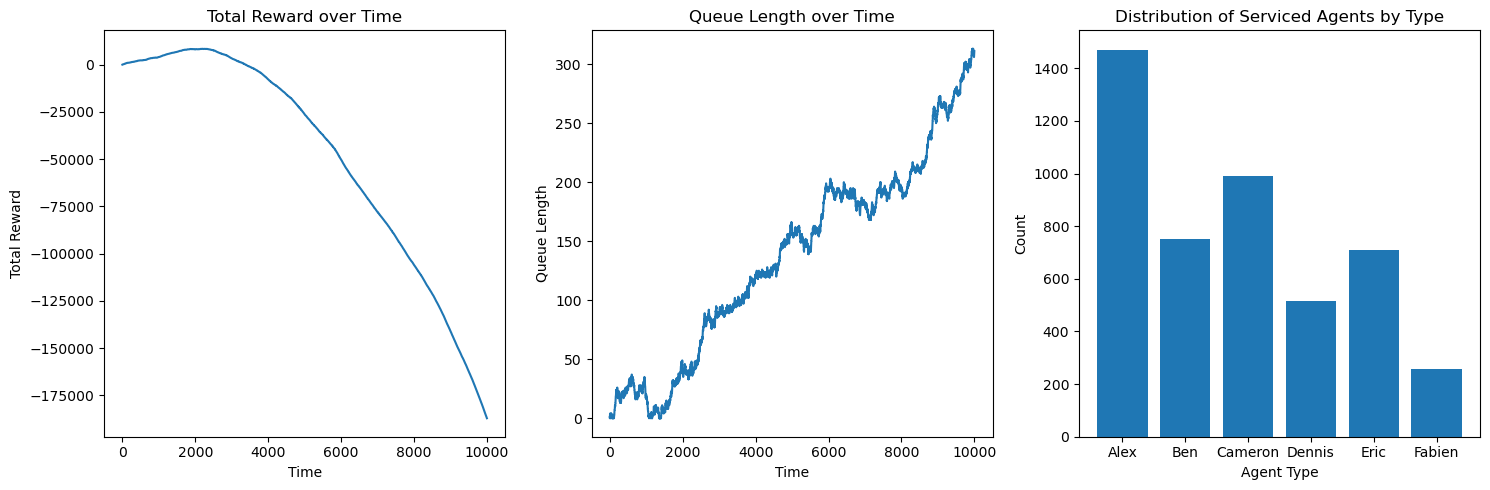


Total reward: -187103.14000145812
Discounted reward: 596.8056055191804
Average reward per step: -18.71031400014581
Min & Max Queue Length: 0 & 313
Mean Queue Length: 136.8866
Normalized Distribution of Serviced Agents: {'Alex': 0.313, 'Cameron': 0.211, 'Ben': 0.16, 'Eric': 0.151, 'Dennis': 0.11, 'Fabien': 0.055}
Time spent busy: 0.9943
--------------------------------------------------------
Running simulation with strategy 'dynamic_strategy'


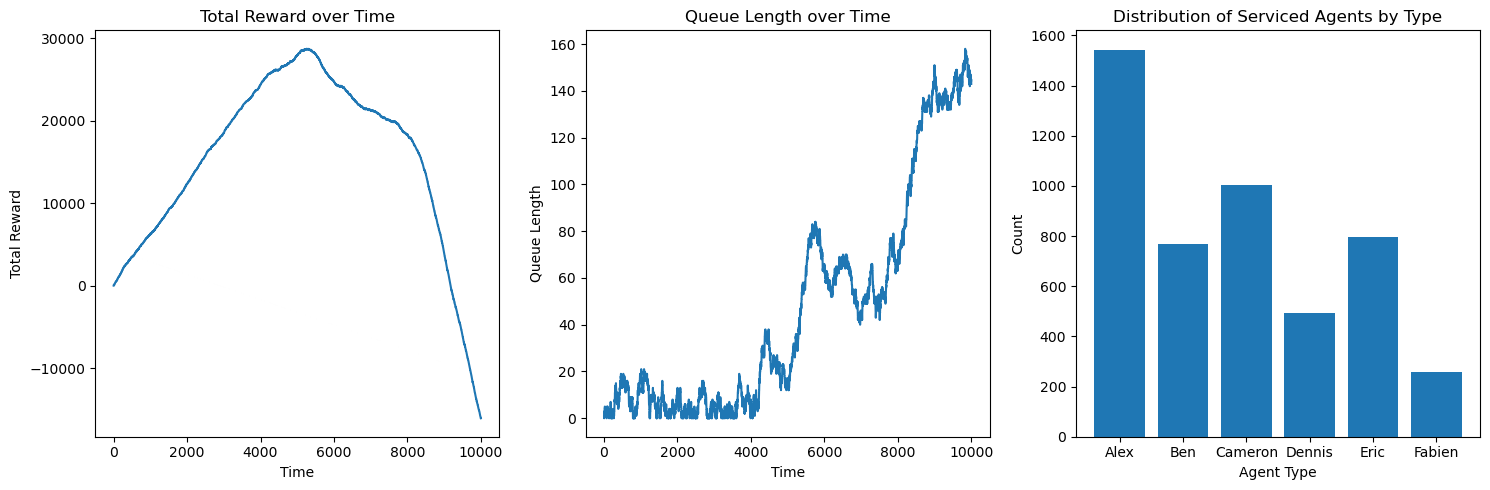


Total reward: -16066.790000026152
Discounted reward: 748.2472157449281
Average reward per step: -1.6066790000026152
Min & Max Queue Length: 0 & 158
Mean Queue Length: 46.9364
Normalized Distribution of Serviced Agents: {'Alex': 0.317, 'Cameron': 0.207, 'Eric': 0.163, 'Ben': 0.158, 'Dennis': 0.102, 'Fabien': 0.053}
Time spent busy: 0.9744
--------------------------------------------------------
Running simulation with strategy 'shortest_service_time_first'


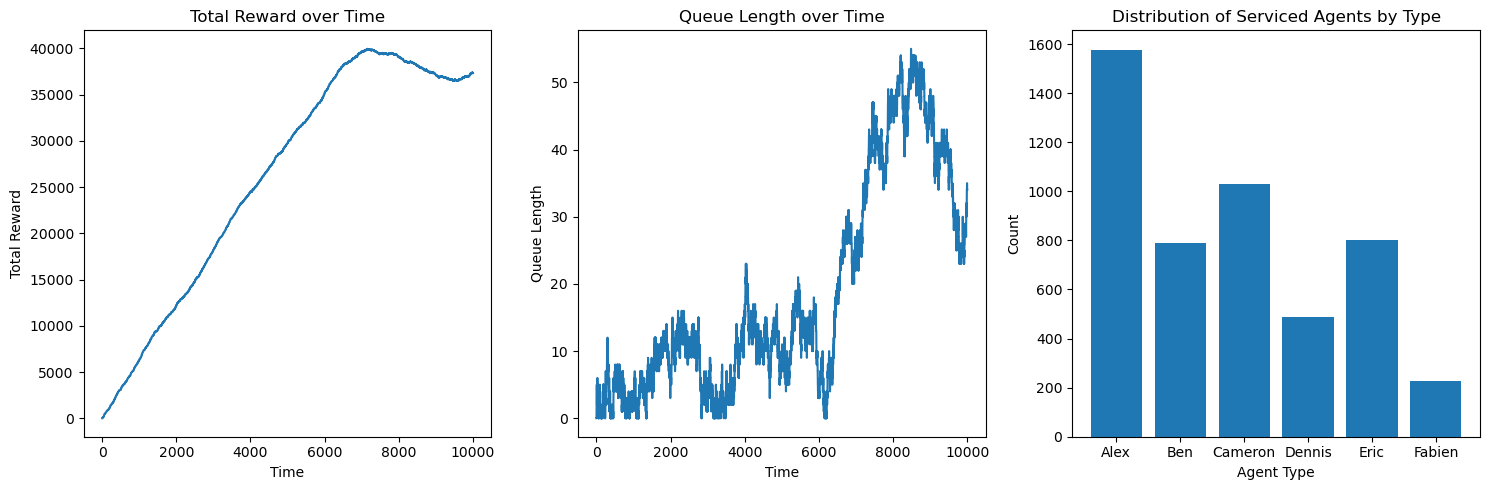


Total reward: 37345.290000367415
Discounted reward: 590.3250619299326
Average reward per step: 3.7345290000367415
Min & Max Queue Length: 0 & 55
Mean Queue Length: 18.6821
Normalized Distribution of Serviced Agents: {'Alex': 0.321, 'Cameron': 0.209, 'Eric': 0.163, 'Ben': 0.161, 'Dennis': 0.099, 'Fabien': 0.046}
Time spent busy: 0.9823
--------------------------------------------------------
Running simulation with strategy 'highest_reward_first'


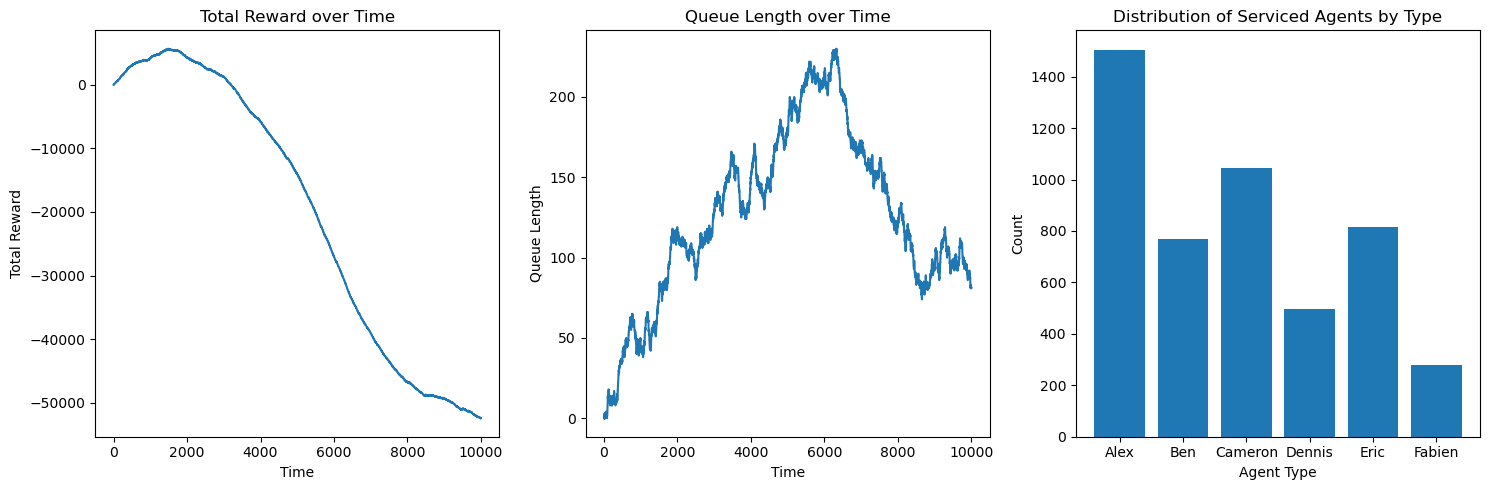


Total reward: -52400.929999075895
Discounted reward: 622.2795091662936
Average reward per step: -5.240092999907589
Min & Max Queue Length: 0 & 230
Mean Queue Length: 126.0218
Normalized Distribution of Serviced Agents: {'Alex': 0.307, 'Cameron': 0.213, 'Eric': 0.166, 'Ben': 0.157, 'Dennis': 0.101, 'Fabien': 0.056}
Time spent busy: 0.9979
--------------------------------------------------------
Running simulation with strategy 'random_selection'


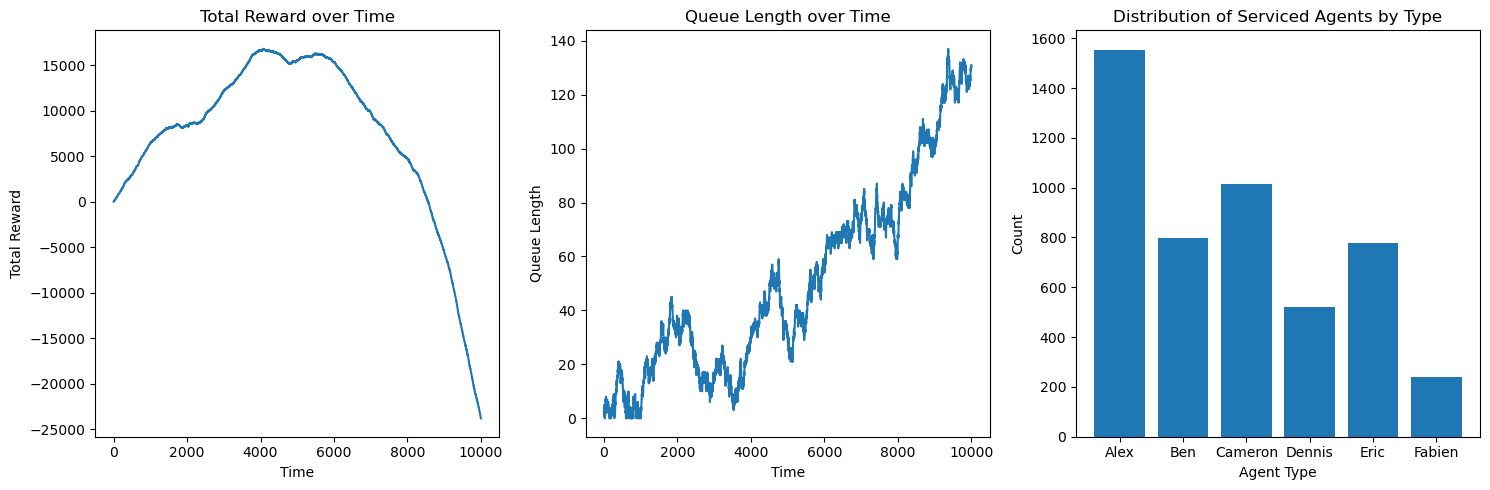


Total reward: -23805.560000099922
Discounted reward: 595.020770416489
Average reward per step: -2.3805560000099923
Min & Max Queue Length: 0 & 137
Mean Queue Length: 50.8972
Normalized Distribution of Serviced Agents: {'Alex': 0.317, 'Cameron': 0.207, 'Ben': 0.162, 'Eric': 0.159, 'Dennis': 0.106, 'Fabien': 0.049}
Time spent busy: 0.9921
--------------------------------------------------------


In [9]:
# Initialize a dictionary to store the results
results = {}

# Print the expected service time and reward + weighted penalty
print(f"Expected service probability & time across agents: {service()}")
print(f"Expected reward + weighted penalty for each agent: {average()}")
print("---------------------------------------------------")

# Add potential variables for some strategies
fixed_priority = ["Fabien", "Eric", "Ben", "Alex", "Cameron", "Dennis"]

# Define the strategies you want to compare
strategies = [
    ("priority_list", priority_list),
    ("first_in_first_served", first_in_first_served),
    ("dynamic_strategy", dynamic_strategy),
    ("shortest_service_time_first", shortest_service_time_first),
    ("highest_reward_first", highest_reward_first),
    ("random_selection", random_selection)
]

# Run the simulation for each strategy
for strategy_name, strategy in strategies:
    simulation = QueueSimulation(agents, arrival_prob, strategy, start, alpha, discount)
    
    print(f"Running simulation with strategy '{strategy_name}'")
    simulation.run_simulation(steps=10000)
    simulation.get_results()
    results[strategy_name] = (simulation.total_reward, simulation.discounted_reward)


### Statistics

Find the strategy with the highest reward

In [10]:
metric = "total_reward" # Choose metric between 'total_reward' and 'discounted_reward'

# Find the strategy with the highest reward based on the selected metric
best_strategy = max(results.items(), key=lambda x: x[1][metric == 'discounted_reward'])
best_strategy_name, best_rewards = best_strategy

print(f"\nBest Strategy: {best_strategy_name} with (total, discounted) reward of {best_rewards}")


Best Strategy: priority_list with (total, discounted) reward of (59601.34999906539, 627.6162892859157)
